<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !mkdir data
# !gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
# !gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
# !unzip -o test.zip -d data
# !unzip -o train.zip -d data

# !git clone https://github.com/Mamiglia/challenge.git

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F 

from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import evaluate_retrieval, visualize_retrieval

In [ ]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")

In [6]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

(125000,)
Train data: 125000 captions, 125000 images


(1536, 1024)

In [7]:
# model = MLP().to(DEVICE)
# print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Train
# print("\n3. Training...")
# model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR)

# # Load best model for evaluation
# model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
# ===============================================================
# 1️⃣ Costruzione delle coppie di ancore (caption ↔ immagine)
# ===============================================================
def build_anchor_pairs(train_data, K=512, seed=0):
    rng = np.random.default_rng(seed)

    img_emb  = torch.from_numpy(train_data['images/embeddings']).float()  # [N_img, 1536]
    cap_emb  = torch.from_numpy(train_data['captions/embeddings']).float()# [N_cap, 1024]
    cap_lbl  = train_data['captions/label']                               # [N_cap, N_img]

    N_img = img_emb.shape[0]
    anchor_img_idx = rng.choice(N_img, size=min(K, N_img), replace=False)

    anchor_caps_idx = []
    for j in anchor_img_idx:
        rows = np.nonzero(cap_lbl[:, j])[0]
        if len(rows) == 0:
            continue
        anchor_caps_idx.append(int(rng.choice(rows, size=1)[0]))

    L = min(len(anchor_img_idx), len(anchor_caps_idx))
    anchor_img_idx = anchor_img_idx[:L]
    anchor_caps_idx = anchor_caps_idx[:L]

    A_X = cap_emb[anchor_caps_idx].clone()   # [K, 1024]
    A_Y = img_emb[anchor_img_idx].clone()    # [K, 1536]

    # Normalizzazione per la cosine distance
    A_X = torch.nn.functional.normalize(A_X, dim=-1)
    A_Y = torch.nn.functional.normalize(A_Y, dim=-1)

    return A_X.to(DEVICE), A_Y.to(DEVICE), anchor_caps_idx, anchor_img_idx

# ===============================================================
# 2️⃣ Traduttore zero-shot con kernel gaussiano + centratura
# ===============================================================
def zero_shot_translate_gaussian(X, A_X, A_Y, sigma=1.0, topk=64):
    """
    Zero-shot translation con kernel gaussiano euclideo stabile + centratura.
    """
    # Normalizza
    Xn = torch.nn.functional.normalize(X, dim=-1)
    A_Xn = torch.nn.functional.normalize(A_X, dim=-1)

    # Distanze euclidee quadratiche
    D = torch.cdist(Xn, A_Xn, p=2) ** 2  # [B, K]

    # Masking top-k
    if topk is not None and topk < D.shape[1]:
        vals, idx = torch.topk(-D, k=topk, dim=-1)
        D_masked = torch.full_like(D, float('inf'))
        D_masked.scatter_(dim=-1, index=idx, src=-vals)
        D = D_masked

    # Kernel gaussiano
    W = torch.exp(-D / (2 * sigma ** 2))
    W = W / (W.sum(dim=-1, keepdim=True) + 1e-8)

    # Centratura del manifold visivo
    mu_Y = A_Y.mean(dim=0, keepdim=True)
    Y_hat = (W @ (A_Y - mu_Y)) + mu_Y
    return Y_hat

# ===============================================================
# 3️⃣ Correlazione metrica
# ===============================================================
def metric_correlation(Y_hat, Y_true, sample_size=500):
    """
    Calcola la correlazione tra le distanze pairwise in Y_hat e Y_true.
    """
    N = Y_hat.size(0)
    idx = torch.randperm(N)[:sample_size]
    Yh = torch.nn.functional.normalize(Y_hat[idx], dim=-1)
    Yt = torch.nn.functional.normalize(Y_true[idx], dim=-1)

    Dh = torch.cdist(Yh, Yh)
    Dt = torch.cdist(Yt, Yt)

    dh_flat = Dh.flatten().cpu().numpy()
    dt_flat = Dt.flatten().cpu().numpy()

    rho = np.corrcoef(dh_flat, dt_flat)[0,1]
    return rho

# ===============================================================
# 4️⃣ Sweep automatico su σ e topk
# ===============================================================
def sweep_sigma_topk(Xb, Yb, A_X, A_Y, sigmas, topks):
    print(f"{'σ':<6}{'topk':<8}{'cos':<10}{'mse':<10}{'ρ':<10}")
    print("-"*45)
    for sigma in sigmas:
        for topk in topks:
            with torch.no_grad():
                Y_hat = zero_shot_translate_gaussian(Xb, A_X, A_Y, sigma=sigma, topk=topk)

                cos = torch.nn.functional.cosine_similarity(
                    torch.nn.functional.normalize(Y_hat, dim=-1),
                    torch.nn.functional.normalize(Yb, dim=-1),
                    dim=-1
                ).mean().item()
                
                print("Mean norm pred:", Y_hat.norm(dim=-1).mean().item())
                print("Mean norm true:", Yb.norm(dim=-1).mean().item())
                
                # Calcola la scala globale di norma
                scale = Yb.norm(dim=-1).mean() / Y_hat.norm(dim=-1).mean()
                print(f"Rescaling by factor: {scale:.2f}")

                # Applica la correzione di scala
                Y_hat = Y_hat * scale

                mse = torch.nn.functional.mse_loss(Y_hat, Yb).item()
                rho = metric_correlation(Y_hat, Yb, sample_size=500)
                print(f"{sigma:<6.2f}{topk:<8}{cos:<10.4f}{mse:<10.4f}{rho:<10.4f}")

# ===============================================================
# 5️⃣ ESEMPIO D’USO
# ===============================================================

K = 1024
A_X, A_Y, caps_idx, imgs_idx = build_anchor_pairs(train_data, K=K, seed=0)

Xb, Yb = next(iter(val_loader))
Xb = Xb.to(DEVICE)
Yb = Yb.to(DEVICE)

sigmas = [0.5, 0.8, 1.0, 1.2, 1.5]
topks  = [16, 32, 64, 128]

sweep_sigma_topk(Xb, Yb, A_X, A_Y, sigmas, topks)


σ     topk    cos       mse       ρ         
---------------------------------------------
Mean norm pred: 0.7926622033119202
Mean norm true: 25.82465362548828
Rescaling by factor: 32.58
0.50  16      0.7889    0.1849    0.4571    
Mean norm pred: 0.780078113079071
Mean norm true: 25.82465362548828
Rescaling by factor: 33.11
0.50  32      0.7909    0.1833    0.4428    
Mean norm pred: 0.7707083225250244
Mean norm true: 25.82465362548828
Rescaling by factor: 33.51
0.50  64      0.7891    0.1850    0.4356    
Mean norm pred: 0.7643170356750488
Mean norm true: 25.82465362548828
Rescaling by factor: 33.79
0.50  128     0.7848    0.1888    0.4337    
Mean norm pred: 0.7901120781898499
Mean norm true: 25.82465362548828
Rescaling by factor: 32.68
0.80  16      0.7865    0.1870    0.4485    
Mean norm pred: 0.777982234954834
Mean norm true: 25.82465362548828
Rescaling by factor: 33.19
0.80  32      0.7882    0.1858    0.4369    
Mean norm pred: 0.7688201069831848
Mean norm true: 25.82465362548

In [ ]:
# ===============================================================
# 6️⃣ Valutazione completa su validation set
# ===============================================================
def orthogonal_procrustes(X, Y):
    U, _, Vt = torch.linalg.svd(X.T @ Y)
    return U @ Vt

# Genera predizioni con kernel sharpened
with torch.no_grad():
    z_pred_val = zero_shot_translate_gaussian(
        X_val.to(DEVICE), A_X, A_Y,
        sigma=0.5, topk=16
    ).cpu()

z_img_val = y_val.cpu()
gt_indices = np.arange(len(z_img_val))

# === CORREZIONI GLOBALI ===
mean_pred = z_pred_val.norm(dim=-1).mean()
mean_true = z_img_val.norm(dim=-1).mean()
scale = mean_true / mean_pred
print(f"🔧 Rescaling embeddings by factor: {scale:.2f}")
z_pred_val = z_pred_val * scale

R = orthogonal_procrustes(z_pred_val, z_img_val)
z_pred_val = z_pred_val @ R
print("🔄 Applied orthogonal alignment (Procrustes)")

Yp_aug = torch.cat([z_pred_val, torch.ones(z_pred_val.size(0), 1)], dim=1)
W = torch.linalg.lstsq(Yp_aug, z_img_val).solution
z_pred_val = Yp_aug @ W

# === EVALUATION ===
results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=z_img_val,
    gt_indices=gt_indices,
    max_indices=50,
    batch_size=128
)

print("\n=== Retrieval evaluation without training ===")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")

🔧 Rescaling embeddings by factor: 32.55
🔄 Applied orthogonal alignment (Procrustes)

=== Retrieval evaluation (validation set, α=2.0) ===
         mrr: 0.3248
        ndcg: 0.4702
 recall_at_1: 0.1302
 recall_at_3: 0.3914
 recall_at_5: 0.6398
recall_at_10: 0.7882
recall_at_50: 0.9738
     l2_dist: 14.7473


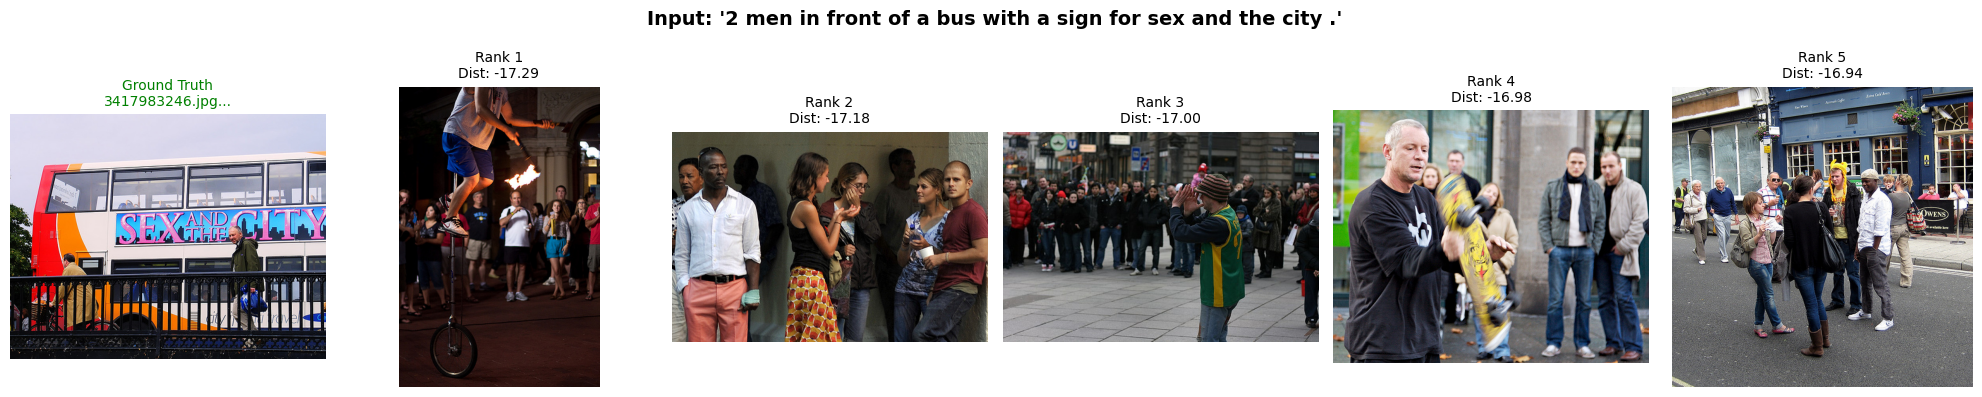

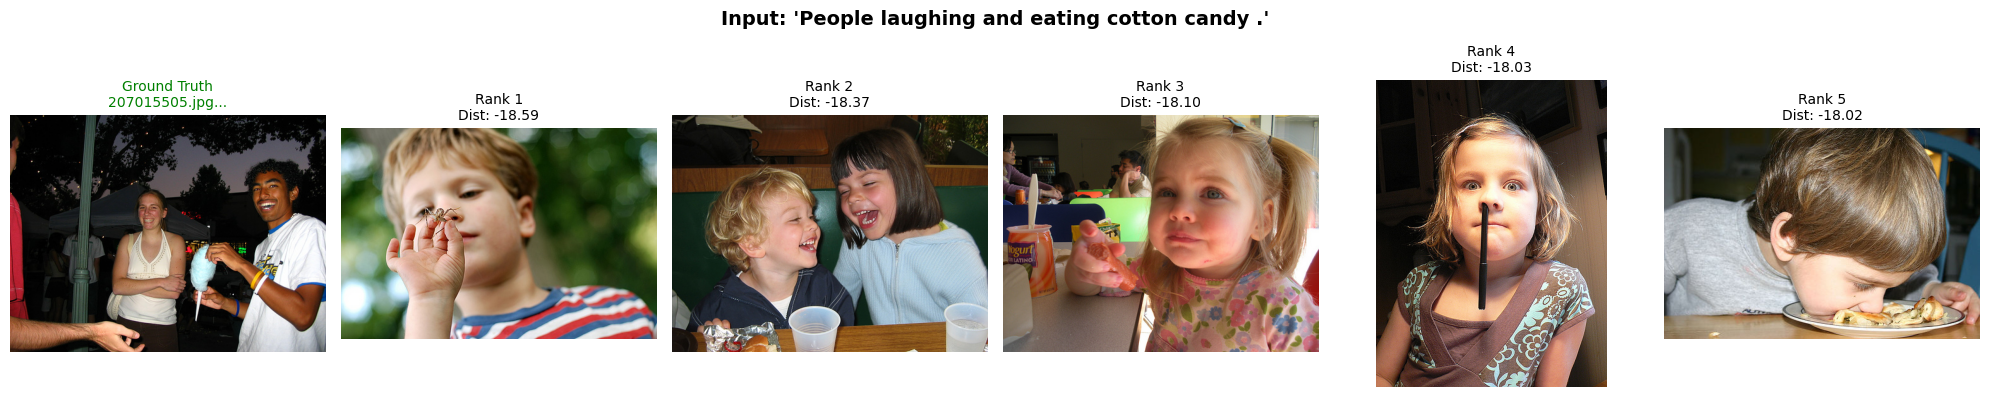

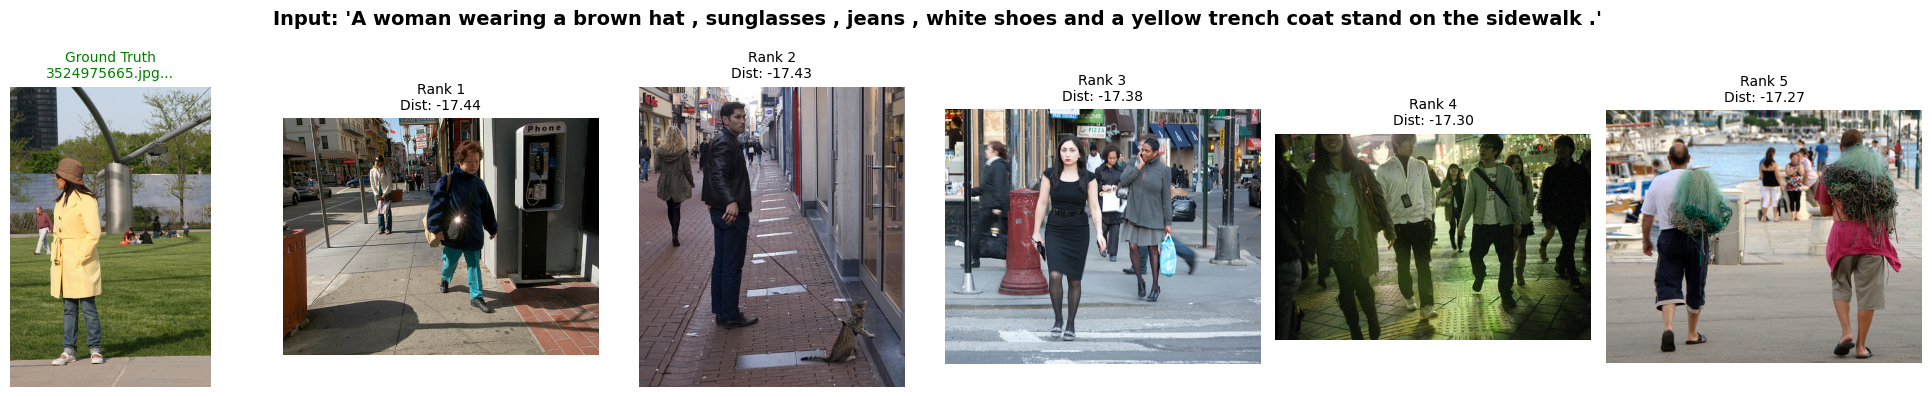

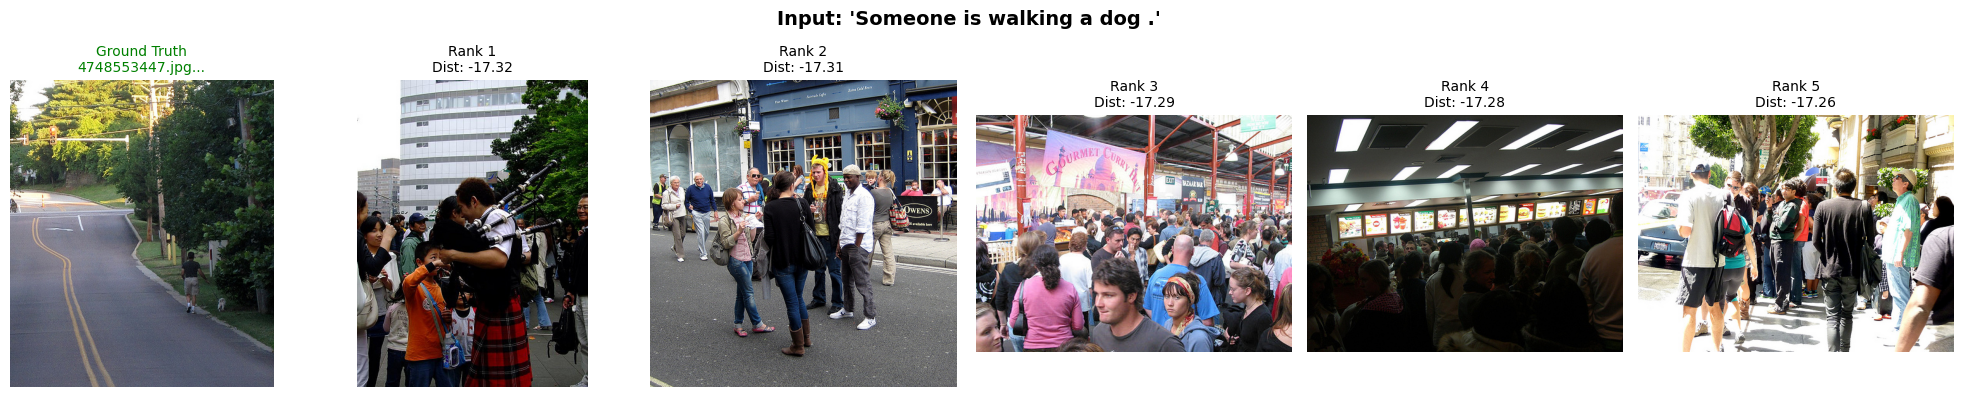

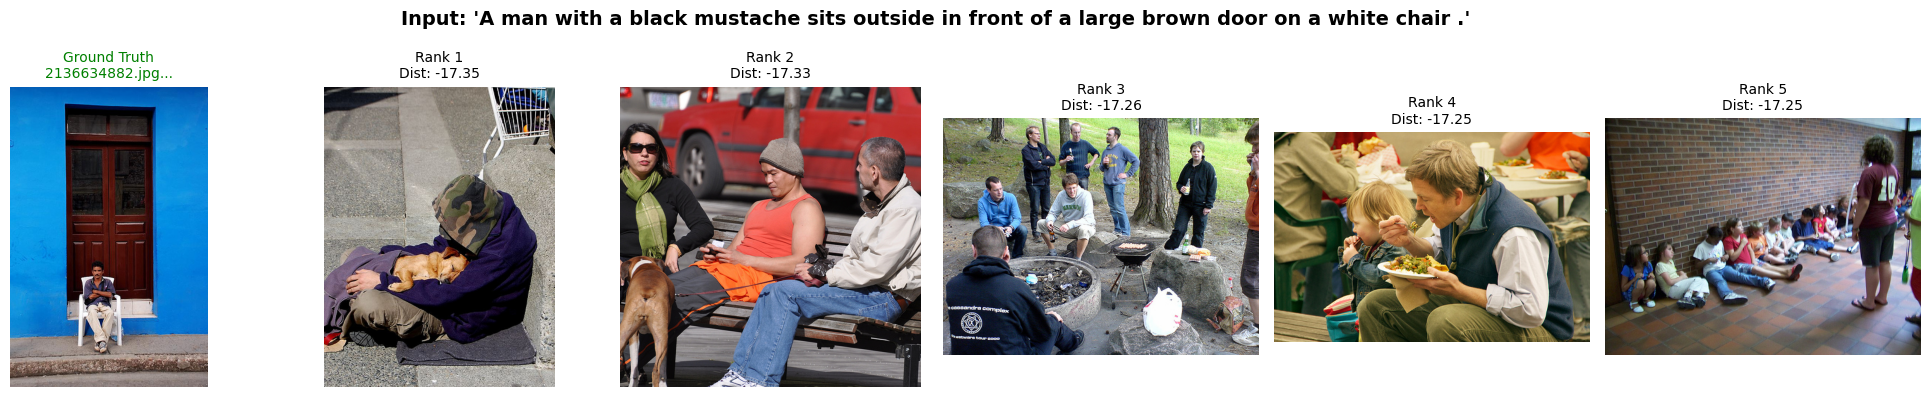

In [13]:
val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Visualizza 5 esempi random
for i in range(5):
    idx = np.random.randint(0, len(val_text_embd))
    caption_embd = val_text_embd[idx:idx+1].to(DEVICE)
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = zero_shot_translate_gaussian(
            caption_embd, A_X, A_Y, sigma=0.5, topk=16
        ).cpu()

    visualize_retrieval(
        pred_embds,
        gt_index,
        val_img_file,
        caption_text,
        val_img_embd,
        k=5
    )


In [52]:
class ResidualAdapter(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + output_dim, hidden),
            nn.GELU(),
            nn.LayerNorm(hidden),
            nn.Dropout(0.1),
            nn.Linear(hidden, output_dim),
            nn.Tanh()
        )
    def forward(self, x, geo_pred):
        return geo_pred + self.net(torch.cat([x, geo_pred], dim=-1))


In [53]:
def info_nce_hard(pred, target, temp=0.07, hard_k=10):
    pred_n = F.normalize(pred, dim=-1)
    targ_n = F.normalize(target, dim=-1)
    sim = pred_n @ targ_n.T / temp  # [B,B]
    # tieni solo i top-k negativi più simili
    mask = torch.eye(sim.size(0), device=sim.device).bool()
    sim_neg = sim.masked_fill(mask, -9e9)
    topk_vals, _ = torch.topk(sim_neg, k=hard_k, dim=1)
    sim_hard = torch.cat([sim.diag().unsqueeze(1), topk_vals], dim=1)
    labels = torch.zeros(sim.size(0), dtype=torch.long, device=sim.device)
    return F.cross_entropy(sim_hard, labels)


In [54]:
def train_residual_model(model, train_loader, val_loader, A_X, A_Y,
                         sigma=0.8, topk=16, lr=1e-4, epochs=10, device="cpu"):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr,
        epochs=epochs, steps_per_epoch=len(train_loader))
    best_val = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for Xb, Yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            Xb, Yb = Xb.to(device), Yb.to(device)

            # --- previsioni geometriche (fisse, non backpropagate) ---
            with torch.no_grad():
                sigma = np.random.uniform(0.7, 1.0)
                topk  = np.random.choice([16, 32])
                geo_pred = zero_shot_translate_gaussian(
                    Xb, A_X, A_Y, sigma=sigma, topk=topk)

            # --- modello residuo ---
            Y_pred = model(Xb, geo_pred)

            # --- loss ---
            mse = F.mse_loss(Y_pred, Yb)
            cos = 1 - F.cosine_similarity(Y_pred, Yb).mean()
            nce = info_nce_hard(Y_pred, Yb, hard_k=10)
            loss = 0.5*mse + 0.3*cos + 0.2*nce

            opt.zero_grad()
            loss.backward()
            opt.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                geo_pred = zero_shot_translate_gaussian(Xb, A_X, A_Y, sigma=sigma, topk=topk)
                Y_pred = model(Xb, geo_pred)
                mse = F.mse_loss(Y_pred, Yb)
                cos = 1 - F.cosine_similarity(Y_pred, Yb).mean()
                val_loss += (0.7*mse + 0.3*cos).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: train={train_loss:.4f} | val={val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "models/residual_adapter_best.pth")
            print(f"  ✓ Saved best model (val_loss={val_loss:.4f})")
    return model


In [ ]:
# costruisci le ancore
K = 1024
A_X, A_Y, _, _ = build_anchor_pairs(train_data, K=K, seed=1234)

# inizializza il modello
model = ResidualAdapter().to(DEVICE)

# addestra
model = train_residual_model(
    model, train_loader, val_loader,
    A_X, A_Y,
    sigma=0.8, topk=16,
    lr=1e-4, epochs=20, device=DEVICE
)

Epoch 1/20: 100%|██████████| 440/440 [00:09<00:00, 48.67it/s]


Epoch 1: train=0.9389 | val=0.4044
  ✓ Saved best model (val_loss=0.4044)


Epoch 2/20: 100%|██████████| 440/440 [00:08<00:00, 50.74it/s]


Epoch 2: train=0.7489 | val=0.3393
  ✓ Saved best model (val_loss=0.3393)


Epoch 3/20: 100%|██████████| 440/440 [00:08<00:00, 52.71it/s]


Epoch 3: train=0.6761 | val=0.3177
  ✓ Saved best model (val_loss=0.3177)


Epoch 4/20: 100%|██████████| 440/440 [00:08<00:00, 50.72it/s]


Epoch 4: train=0.6353 | val=0.3052
  ✓ Saved best model (val_loss=0.3052)


Epoch 5/20: 100%|██████████| 440/440 [00:08<00:00, 51.87it/s]


Epoch 5: train=0.5966 | val=0.2923
  ✓ Saved best model (val_loss=0.2923)


Epoch 6/20: 100%|██████████| 440/440 [00:08<00:00, 53.05it/s]


Epoch 6: train=0.5656 | val=0.2885
  ✓ Saved best model (val_loss=0.2885)


Epoch 7/20: 100%|██████████| 440/440 [00:08<00:00, 50.43it/s]


Epoch 7: train=0.5472 | val=0.2878
  ✓ Saved best model (val_loss=0.2878)


Epoch 8/20: 100%|██████████| 440/440 [00:08<00:00, 49.83it/s]


Epoch 8: train=0.5321 | val=0.2886


Epoch 9/20: 100%|██████████| 440/440 [00:08<00:00, 50.13it/s]


Epoch 9: train=0.5181 | val=0.2867
  ✓ Saved best model (val_loss=0.2867)


Epoch 10/20: 100%|██████████| 440/440 [00:08<00:00, 50.30it/s]


Epoch 10: train=0.5057 | val=0.2885


Epoch 11/20: 100%|██████████| 440/440 [00:08<00:00, 50.17it/s]


Epoch 11: train=0.4943 | val=0.2890


Epoch 12/20: 100%|██████████| 440/440 [00:08<00:00, 51.04it/s]


Epoch 12: train=0.4840 | val=0.2907


Epoch 13/20: 100%|██████████| 440/440 [00:08<00:00, 48.91it/s]


Epoch 13: train=0.4748 | val=0.2898


Epoch 14/20: 100%|██████████| 440/440 [00:08<00:00, 51.48it/s]


Epoch 14: train=0.4672 | val=0.2917


Epoch 15/20: 100%|██████████| 440/440 [00:08<00:00, 52.94it/s]


Epoch 15: train=0.4606 | val=0.2928


Epoch 16/20: 100%|██████████| 440/440 [00:08<00:00, 53.95it/s]


Epoch 16: train=0.4552 | val=0.2929


Epoch 17/20: 100%|██████████| 440/440 [00:08<00:00, 52.84it/s]


Epoch 17: train=0.4510 | val=0.2939


Epoch 18/20: 100%|██████████| 440/440 [00:08<00:00, 52.74it/s]


Epoch 18: train=0.4480 | val=0.2937


Epoch 19/20: 100%|██████████| 440/440 [00:08<00:00, 53.83it/s]


Epoch 19: train=0.4466 | val=0.2939


Epoch 20/20: 100%|██████████| 440/440 [00:08<00:00, 53.81it/s]


Epoch 20: train=0.4453 | val=0.2939


In [ ]:
val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Visualizza 5 esempi random
for i in range(5):
    idx = np.random.randint(0, len(val_text_embd))
    caption_embd = val_text_embd[idx:idx+1].to(DEVICE)
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = zero_shot_translate_gaussian(
            caption_embd, A_X, A_Y, sigma=0.5, topk=16
        ).cpu()

    visualize_retrieval(
        pred_embds,
        gt_index,
        val_img_file,
        caption_text,
        val_img_embd,
        k=5
    )


In [56]:
with torch.no_grad():
    geo_pred = zero_shot_translate_gaussian(X_val.to(DEVICE), A_X, A_Y, sigma=0.8, topk=16)
    z_pred_val = model(X_val.to(DEVICE), geo_pred).cpu()

# correzioni metriche
mean_pred = z_pred_val.norm(dim=-1).mean()
mean_true = y_val.norm(dim=-1).mean()
scale = mean_true / mean_pred
z_pred_val *= scale
R = orthogonal_procrustes(z_pred_val, y_val.cpu())
z_pred_val = z_pred_val @ R

# valutazione
results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=y_val.cpu(),
    gt_indices=np.arange(len(y_val)),
    max_indices=50,
    batch_size=128
)
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")


         mrr: 0.4357
        ndcg: 0.5714
 recall_at_1: 0.1908
 recall_at_3: 0.5647
 recall_at_5: 0.9237
recall_at_10: 0.9756
recall_at_50: 0.9994
     l2_dist: 19.4706


In [41]:
test_data = load_data("data/test/test.clean.npz")
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()

model = ResidualAdapter().to(DEVICE)
model.load_state_dict(torch.load("models/residual_adapter_best.pth"))
model.eval()

with torch.no_grad():
    geo_pred = zero_shot_translate_gaussian(
        test_embds.to(DEVICE), A_X, A_Y, sigma=0.8, topk=16
    )
    pred_embds = model(test_embds.to(DEVICE), geo_pred).cpu()

# (opzionale) applica la stessa correzione di scala e Procrustes del validation
mean_pred = pred_embds.norm(dim=-1).mean()
scale = (A_Y.norm(dim=-1).mean() / mean_pred).item()  # float puro
pred_embds *= scale

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print("✅ Submission saved to: submission.csv")


Generating submission file...
✓ Saved submission to submission.csv
✅ Submission saved to: submission.csv


---

# Visualizzazione degli spazi

In [ ]:
# === Probe stitching: primo modello (X) → adapter (Y_hat) vs spazio target (Y_true) ===
import torch
import torch.nn.functional as F

def _describe(t: torch.Tensor, name: str):
    t = t.detach().float().cpu()
    info = {
        "shape": tuple(t.shape),
        "dtype": str(t.dtype),
        "mean": float(t.mean()),
        "std": float(t.std()),
        "min": float(t.min()),
        "max": float(t.max()),
    }
    # l2 medio per batch [N, D]
    if t.ndim == 2:
        with torch.no_grad():
            info["l2_mean"] = float(t.norm(dim=1).mean())
    print(f"{name}: {info}")
    if t.ndim == 2 and t.size(0) > 0:
        print(f"  sample[0][:8] = {t[0, :8].numpy().round(4).tolist()}")

# prendi un batch (val → preferito; fallback su train)
try:
    Xb, Yb = next(iter(val_loader))
except Exception:
    Xb, Yb = next(iter(train_loader))

Xb = Xb.to(DEVICE)
Yb = Yb.to(DEVICE)

with torch.no_grad():
    Y_hat = model(Xb)

print("— Spazio 1: OUTPUT PRIMO MODELLO (embedding testo) —")
_describe(Xb, "X (text space)")

print("\n— Spazio INTERMEDIO: USCITA ADAPTER/STITCHER —")
_describe(Y_hat, "Y_hat (→ supposed VAE space)")

print("\n— Spazio 2: INPUT 'SECONDO MODELLO' (proxy = target VAE) —")
_describe(Yb, "Y_true (VAE space, proxy)")

# check dimensionale + mini-metriche di allineamento
pdim, ydim = Y_hat.shape[-1], Yb.shape[-1]
print(f"\nCompatibilità dimensioni: pred={pdim}, target={ydim} → {'OK' if pdim == ydim else 'MISMATCH'}")

k = min(64, Y_hat.size(0))
cos = F.cosine_similarity(Y_hat[:k], Yb[:k], dim=1).mean().item()
mse = F.mse_loss(Y_hat[:k], Yb[:k]).item()
print(f"Allineamento (prime {k}): cosine={cos:.4f} | mse={mse:.6f}")

# (opzionale) salva un piccolo snapshot per debug offline/plot
torch.save(
    {"X": Xb[:k].detach().cpu(), "Y_hat": Y_hat[:k].detach().cpu(), "Y_true": Yb[:k].detach().cpu()},
    "debug_probe.pt"
)
print("Snapshot salvato in 'debug_probe.pt' (X, Y_hat, Y_true).")


In [ ]:
# ==== Visual debug degli spazi: X (text), Y_hat (adapter), Y_true (VAE) ====
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

def top_singular_values(T, k=128):
    """
    Calcola i primi valori singolari (spettro) di T
    in modo robusto alla dimensione del batch.
    """
    Tc = (T - T.mean(dim=0, keepdim=True)).detach().float().cpu()
    n_samples, n_features = Tc.shape
    n_comp = min(k, n_samples, n_features, 256)  # safe cap
    if n_comp < 2:
        print(f"[!] Batch troppo piccolo per PCA (n={n_samples}), skip.")
        return np.array([])
    p = PCA(n_components=n_comp).fit(Tc.numpy())
    return p.singular_values_

def load_probe_or_batch(model, train_loader, val_loader, device, k=512):
    # 1) prova a caricare lo snapshot
    if Path("debug_probe.pt").exists():
        d = torch.load("debug_probe.pt", map_location="cpu")
        X = d["X"].float().to(device)
        Y_hat = d["Y_hat"].float().to(device)
        Y_true = d["Y_true"].float().to(device)
        return X, Y_hat, Y_true

    # 2) altrimenti crea un batch ad hoc
    try:
        Xb, Yb = next(iter(val_loader))
    except Exception:
        Xb, Yb = next(iter(train_loader))
    Xb = Xb.to(device)
    Yb = Yb.to(device)
    with torch.no_grad():
        Yhat = model(Xb)
    # sottocampiona per grafici
    k = min(k, Xb.size(0))
    return Xb[:k], Yhat[:k], Yb[:k]

def pca2d_plot(T, title):
    T = T.detach().float().cpu().numpy()
    p = PCA(n_components=2).fit_transform(T)
    plt.figure()
    plt.scatter(p[:,0], p[:,1], s=6, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

def l2_norms(t):
    return t.detach().float().cpu().norm(dim=1).numpy()

def cosine_batch(a, b):
    with torch.no_grad():
        return F.cosine_similarity(a, b, dim=1).detach().cpu().numpy()

def pairwise_distances(t, nmax=300):
    t = t.detach().float().cpu()
    n = min(nmax, t.size(0))
    t = t[:n]
    # normalizza per stabilità opzionale
    # t = F.normalize(t, dim=1)
    d2 = torch.cdist(t, t, p=2)  # [n, n]
    return d2.flatten().numpy()

def corr_pearson_spearman(x, y):
    # calcolo manuale Pearson; Spearman via ranking
    x = np.asarray(x)
    y = np.asarray(y)
    # Pearson
    px = x - x.mean()
    py = y - y.mean()
    pearson = (px*py).sum() / (np.sqrt((px**2).sum()) * np.sqrt((py**2).sum()) + 1e-12)
    # Spearman
    rx = x.argsort().argsort().astype(float)
    ry = y.argsort().argsort().astype(float)
    rpx = rx - rx.mean()
    rpy = ry - ry.mean()
    spearman = (rpx*rpy).sum() / (np.sqrt((rpx**2).sum()) * np.sqrt((rpy**2).sum()) + 1e-12)
    return float(pearson), float(spearman)

# ==== 1) Carica tensori ====
X, Y_hat, Y_true = load_probe_or_batch(model, train_loader, val_loader, DEVICE, k=1024)
print("Batch:", tuple(X.shape), tuple(Y_hat.shape), tuple(Y_true.shape))

# ==== 2) PCA 2D separata per ciascuno spazio ====
pca2d_plot(X,      "PCA 2D — Spazio testo (X)")
pca2d_plot(Y_hat,  "PCA 2D — Adapter output (Y_hat → VAE)")
pca2d_plot(Y_true, "PCA 2D — Target VAE (Y_true)")

# ==== 3) Istogramma norme L2 (confronto) ====
nx = l2_norms(X); nyh = l2_norms(Y_hat); nyt = l2_norms(Y_true)
plt.figure()
bins = 40
plt.hist(nx, bins=bins, alpha=0.5, label="X (text)")
plt.hist(nyh, bins=bins, alpha=0.5, label="Y_hat")
plt.hist(nyt, bins=bins, alpha=0.5, label="Y_true")
plt.title("Distribuzione norme L2")
plt.xlabel("||v||2")
plt.ylabel("freq")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Norme — mean: X={nx.mean():.3f}, Y_hat={nyh.mean():.3f}, Y_true={nyt.mean():.3f}")

# ==== 4) Cosine(Y_hat, Y_true): distribuzione ====
cos_vals = cosine_batch(Y_hat, Y_true)
plt.figure()
plt.hist(cos_vals, bins=40, alpha=0.8)
plt.title("Distribuzione cosine(Y_hat, Y_true)")
plt.xlabel("cosine")
plt.ylabel("freq")
plt.tight_layout()
plt.show()
print(f"Cosine — mean={cos_vals.mean():.4f}, std={cos_vals.std():.4f}, min={cos_vals.min():.4f}, max={cos_vals.max():.4f}")

# ==== 5) Preservazione geometrica: correlazione tra distanze pairwise ====
dYh = pairwise_distances(Y_hat, nmax=400)
dYt = pairwise_distances(Y_true, nmax=400)
pear, spear = corr_pearson_spearman(dYh, dYt)
print(f"Corr(dists Y_hat vs Y_true) — Pearson={pear:.4f}, Spearman={spear:.4f}")

# ==== 6) (Opzionale) Analisi anisotropia: spettro singolare (primi 128 valori) ====
def top_singular_values(T, k=128):
    # centratura per guardare la varianza
    Tc = (T - T.mean(dim=0, keepdim=True)).detach().float().cpu()
    # usa SVD economica su [N x D] se N >= D, altrimenti PCA già fatto sopra
    # Qui facciamo PCA per robustezza
    n_comp = min(k, Tc.shape[1], 256)
    p = PCA(n_components=n_comp).fit(Tc.numpy())
    return p.singular_values_

sv_x   = top_singular_values(X)
sv_yh  = top_singular_values(Y_hat)
sv_yt  = top_singular_values(Y_true)

plt.figure()
plt.plot(sv_x,  label="X")
plt.plot(sv_yh, label="Y_hat")
plt.plot(sv_yt, label="Y_true")
plt.title("Spettro (singular values) — andamento")
plt.xlabel("indice componente")
plt.ylabel("singular value")
plt.legend()
plt.tight_layout()
plt.show()

# ==== 7) (Opzionale) Calibrazione affine batch-wise + nuovo check ====
with torch.no_grad():
    mu_pred = Y_hat.mean(dim=0, keepdim=True)
    sd_pred = Y_hat.std(dim=0, keepdim=True) + 1e-6
    mu_true = Y_true.mean(dim=0, keepdim=True)
    sd_true = Y_true.std(dim=0, keepdim=True) + 1e-6
    Y_hat_cal = (Y_hat - mu_pred) * (sd_true / sd_pred) + mu_true  # per-dimension mean/std match

    # alternativamente, sola scala globale "temperature" alpha:
    num = (Y_hat * Y_true).sum()
    den = (Y_hat * Y_hat).sum() + 1e-12
    alpha = (num / den).item()
    Y_hat_alpha = Y_hat * alpha

    # metriche
    cos_raw   = F.cosine_similarity(Y_hat,      Y_true, dim=1).mean().item()
    cos_cal   = F.cosine_similarity(Y_hat_cal,  Y_true, dim=1).mean().item()
    cos_alpha = F.cosine_similarity(Y_hat_alpha,Y_true, dim=1).mean().item()
    mse_raw   = F.mse_loss(Y_hat,      Y_true).item()
    mse_cal   = F.mse_loss(Y_hat_cal,  Y_true).item()
    mse_alpha = F.mse_loss(Y_hat_alpha,Y_true).item()

print(f"[Raw]    cosine={cos_raw:.4f} | mse={mse_raw:.6f}")
print(f"[Affine] cosine={cos_cal:.4f} | mse={mse_cal:.6f}  (per-dim mean/std match)")
print(f"[Alpha]  cosine={cos_alpha:.4f} | mse={mse_alpha:.6f}  (scala globale α={alpha:.3f})")


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# === Carica i tensori dal file o da un batch ===
try:
    probe = torch.load("debug_probe.pt", map_location="cpu")
    X = probe["X"]
    Y_hat = probe["Y_hat"]
    Y_true = probe["Y_true"]
    print("Caricato debug_probe.pt")
except FileNotFoundError:
    print("⚠️ debug_probe.pt non trovato, prendo un batch.")
    Xb, Yb = next(iter(val_loader))
    X = Xb.cpu()
    with torch.no_grad():
        Y_hat = model(Xb.to(DEVICE)).cpu()
    Y_true = Yb.cpu()

# === PCA separata (riduzione a 3D per ciascun spazio) ===
N = min(800, X.size(0))

def to_pca3(t):
    p = PCA(n_components=3)
    return p.fit_transform(t[:N].numpy())

X3 = to_pca3(X)
Yh3 = to_pca3(Y_hat)
Yt3 = to_pca3(Y_true)

# === Crea figure interattiva ===
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X3[:, 0], y=X3[:, 1], z=X3[:, 2],
    mode='markers',
    marker=dict(size=3, color='royalblue', opacity=0.6),
    name='Text space (X)'
))

fig.add_trace(go.Scatter3d(
    x=Yh3[:, 0], y=Yh3[:, 1], z=Yh3[:, 2],
    mode='markers',
    marker=dict(size=3, color='mediumorchid', opacity=0.6),
    name='Adapter output (Y_hat)'
))

fig.add_trace(go.Scatter3d(
    x=Yt3[:, 0], y=Yt3[:, 1], z=Yt3[:, 2],
    mode='markers',
    marker=dict(size=3, color='gold', opacity=0.6),
    name='VAE space (Y_true)'
))

# === Layout ===
fig.update_layout(
    title="Visualizzazione 3D interattiva degli spazi latenti (PCA 3D)",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        bgcolor='rgba(240,240,240,1)'
    ),
    legend=dict(x=0.02, y=0.98),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# === Carica i tensori (da debug_probe o batch) ===
try:
    probe = torch.load("debug_probe.pt", map_location="cpu")
    X = probe["X"]
    Y_hat = probe["Y_hat"]
    Y_true = probe["Y_true"]
    print("Caricato debug_probe.pt")
except FileNotFoundError:
    print("⚠️ debug_probe.pt non trovato, prendo un batch.")
    Xb, Yb = next(iter(val_loader))
    X = Xb.cpu()
    with torch.no_grad():
        Y_hat = model(Xb.to(DEVICE)).cpu()
    Y_true = Yb.cpu()

# === Parametri ===
N = min(600, X.size(0))  # sottocampiona per velocità
perplexity = 30

# === t-SNE separato per ciascuno spazio ===
def to_tsne3(t):
    t_np = t[:N].numpy()
    tsne = TSNE(
        n_components=3, perplexity=perplexity, learning_rate='auto',
        init='pca', n_iter=1500, verbose=0
    )
    return tsne.fit_transform(t_np)

print("Eseguo t-SNE (può richiedere 1–2 min)...")

X3 = to_tsne3(X)
Yh3 = to_tsne3(Y_hat)
Yt3 = to_tsne3(Y_true)

# === Crea figura interattiva ===
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X3[:, 0], y=X3[:, 1], z=X3[:, 2],
    mode='markers',
    marker=dict(size=3, color='royalblue', opacity=0.6),
    name='Text space (X)'
))

fig.add_trace(go.Scatter3d(
    x=Yh3[:, 0], y=Yh3[:, 1], z=Yh3[:, 2],
    mode='markers',
    marker=dict(size=3, color='mediumorchid', opacity=0.6),
    name='Adapter output (Y_hat)'
))

fig.add_trace(go.Scatter3d(
    x=Yt3[:, 0], y=Yt3[:, 1], z=Yt3[:, 2],
    mode='markers',
    marker=dict(size=3, color='gold', opacity=0.6),
    name='VAE space (Y_true)'
))

fig.update_layout(
    title=f"Visualizzazione 3D (t-SNE separato, perplexity={perplexity})",
    scene=dict(
        xaxis_title='t-SNE 1',
        yaxis_title='t-SNE 2',
        zaxis_title='t-SNE 3',
        bgcolor='rgba(245,245,245,1)'
    ),
    legend=dict(x=0.02, y=0.98),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [ ]:
# === Visualizza output del primo modello e input (proxy) del secondo ===
Xb, Yb = next(iter(val_loader))  # oppure train_loader se preferisci
Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)

with torch.no_grad():
    Y_hat = model(Xb)

print("🟦 Output del primo modello (embedding testo):")
print(Xb[0])

plt.figure()
plt.plot(Xb[0].cpu())
plt.plot(Yb[0].cpu())
plt.tight_layout()
plt.show()

print("\n🟨 Input del secondo modello (proxy = embedding immagine / target):")
print(Yb[0])

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Embedding predetto (dal tuo codice sopra)
with torch.no_grad():
    pred_embd = model(caption_embd).cpu()

# Tutte le embedding immagini
all_img_embd = torch.from_numpy(train_data['images/embeddings']).float()
all_img_names = train_data['images/names']

# Similarità coseno tra predizione e tutte le immagini
cosine_sims = torch.nn.functional.cosine_similarity(pred_embd, all_img_embd)
best_idx = torch.argmax(cosine_sims).item()
best_name = all_img_names[best_idx]
best_sim = cosine_sims[best_idx].item()

# Visualizza confronto
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Target reale
try:
    true_img = Image.open(img_path)
    ax[0].imshow(true_img)
    ax[0].set_title("Immagine target reale")
except:
    ax[0].text(0.5, 0.5, "Mancante", ha="center", va="center")

# Più vicina secondo il modello
try:
    pred_img = Image.open(Path("data/train/images") / best_name)
    ax[1].imshow(pred_img)
    ax[1].set_title(f"Predetta (retrieval top-1)\ncosine={best_sim:.3f}")
except:
    ax[1].text(0.5, 0.5, "Mancante", ha="center", va="center")

for a in ax: a.axis("off")
plt.suptitle("Confronto tra immagine reale e più simile secondo l’adapter", y=0.92)
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Carica gli embedding visivi del VAE
Y_all = torch.from_numpy(train_data['images/embeddings']).float()
print(f"Spazio visivo: {Y_all.shape}")

# 1️⃣ PCA: varianza spiegata
pca = PCA().fit(Y_all)
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Numero di componenti principali")
plt.ylabel("Varianza cumulata")
plt.title("Spettro PCA (VAE space)")
plt.grid(True)
plt.show()

print(f"Varianza spiegata al 95%: {np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.95)} componenti")

# 2️⃣ Curvatura empirica: correlazione distanze euclidee vs geodetiche
n = min(500, len(Y_all))
idx = np.random.choice(len(Y_all), n, replace=False)
Y_sub = Y_all[idx].numpy()

# Distanze euclidee
D_eucl = pairwise_distances(Y_sub, metric='euclidean')

# Distanze geodetiche con Isomap (approssimazione geodetica)
iso = Isomap(n_neighbors=15, n_components=10)
Y_iso = iso.fit_transform(Y_sub)
D_geo = pairwise_distances(Y_iso, metric='euclidean')

# Correlazione tra distanze
corr = np.corrcoef(D_eucl.flatten(), D_geo.flatten())[0,1]
print(f"Correlazione Euclidea–Geodetica: {corr:.4f}")

# 3️⃣ Isotropia: varianza per dimensione
var_per_dim = Y_all.var(dim=0).numpy()
plt.figure(figsize=(6,3))
plt.plot(var_per_dim)
plt.title("Varianza per dimensione (anisotropia)")
plt.xlabel("Dimensione")
plt.ylabel("Varianza")
plt.tight_layout()
plt.show()

print(f"Varianza media: {var_per_dim.mean():.4f},  max/min ratio: {var_per_dim.max()/var_per_dim.min():.2f}")

# 4️⃣ Clusterizzazione (struttura semantica)
k = 15
kmeans = KMeans(n_clusters=k, random_state=0).fit(Y_all)
sil_score = silhouette_score(Y_all, kmeans.labels_)
print(f"Silhouette score (k={k}): {sil_score:.4f}")
